In [5]:
import warnings
warnings.filterwarnings("ignore")

from keras.backend import clear_session
from keras.models import load_model
from keras.optimizers import Adam
from keras.preprocessing import image
import model.keras_layers
from cv2 import imread,resize

from model.models.keras_ssd512 import ssd_512
from model.keras_loss_function.keras_ssd_loss import SSDLoss

import numpy as np
from matplotlib import pyplot as plt

In [38]:
# Set the image size.
img_height = 512
img_width = 512

In [7]:
clear_session()
weights_path = r'model\weights\VGG_VOC0712Plus_SSD_512x512_ft_iter_160000.h5'
model = ssd_512(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
               two_boxes_for_ar1=True,
               steps=[8, 16, 32, 64, 128, 256, 512],
               offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               clip_boxes=False,
               variances=[0.1, 0.1, 0.2, 0.2],
               normalize_coords=True,
               subtract_mean=[123, 117, 104],
               swap_channels=[2, 1, 0],
               confidence_thresh=0.5,
               iou_threshold=0.45,
               top_k=200,
               nms_max_output_size=400)
model.load_weights(weights_path, by_name=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [8]:
img_path = r'C:\Users\HP\Downloads\ECO\cat.JPG'

orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img)
input_images.append(img)
input_images = np.array(input_images)

In [9]:
y_pred = model.predict(input_images)

In [10]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  8.     1.    23.72  -4.09 485.79 506.71]]


[ 23.72  -4.09 485.79 506.71]


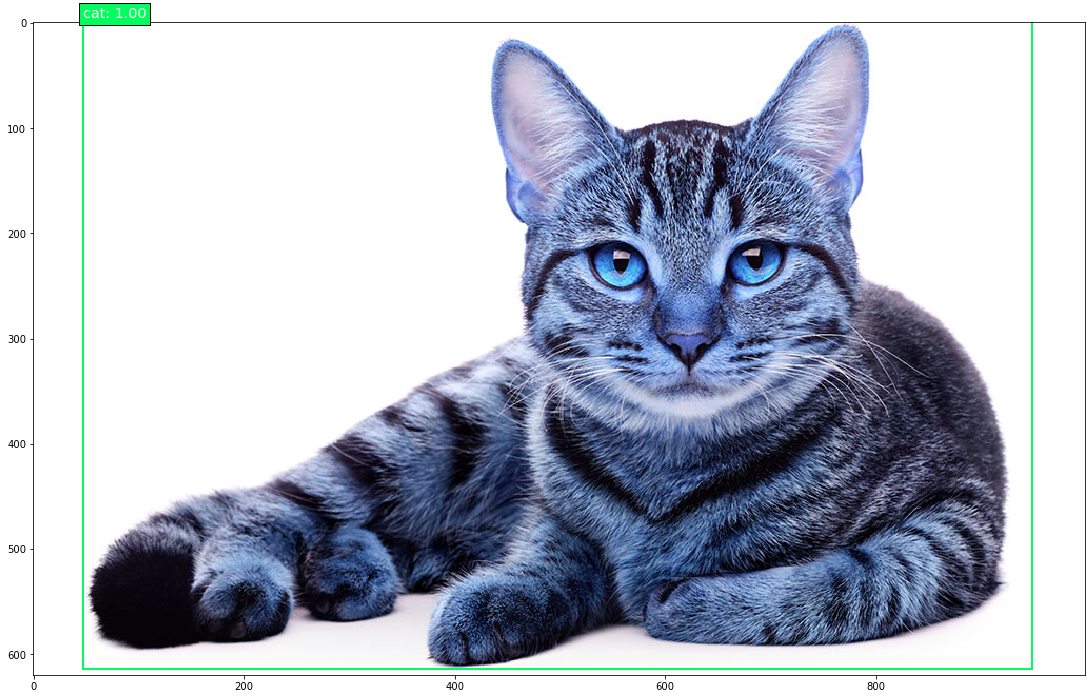

In [11]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    print(box[-4:])
    # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
    xmin = box[-4] * orig_images[0].shape[1] / img_width
    ymin = box[-3] * orig_images[0].shape[0] / img_height
    xmax = box[-2] * orig_images[0].shape[1] / img_width
    ymax = box[-1] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})



In [12]:
from keras.backend import clear_session
from keras.models import load_model
from keras.optimizers import Adam
from keras.preprocessing import image
import model.keras_layers
import cv2
from cv2 import imread,resize

from model.models.keras_ssd512 import ssd_512
from model.keras_loss_function.keras_ssd_loss import SSDLoss

import numpy as np
from matplotlib import pyplot as plt

# Set the image size.
img_height = 512
img_width = 512

weights_path = r'model\weights\VGG_VOC0712Plus_SSD_512x512_ft_iter_160000.h5'


In [13]:
class PersonRecognizer:
    def __init__(self,weights_path=weights_path):
        self.classes = ['background',
                        'aeroplane', 'bicycle', 'bird', 'boat',
                        'bottle', 'bus', 'car', 'cat',
                        'chair', 'cow', 'diningtable', 'dog',
                        'horse', 'motorbike', 'person', 'pottedplant',
                        'sheep', 'sofa', 'train', 'tvmonitor']
        
        self.prediction_order = ['class','confidence','xmin','ymin','xmax','ymax']
        
        model = ssd_512(image_size=(img_height, img_width, 3),
                    n_classes=20,
                    mode='inference',
                    l2_regularization=0.0005,
                    scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                    aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                             [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                             [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                             [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                             [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                             [1.0, 2.0, 0.5],
                                             [1.0, 2.0, 0.5]],
                   two_boxes_for_ar1=True,
                   steps=[8, 16, 32, 64, 128, 256, 512],
                   offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                   clip_boxes=False,
                   variances=[0.1, 0.1, 0.2, 0.2],
                   normalize_coords=True,
                   subtract_mean=[123, 117, 104],
                   swap_channels=[2, 1, 0],
                   confidence_thresh=0.5,
                   iou_threshold=0.45,
                   top_k=200,
                   nms_max_output_size=400)
        
        model.load_weights(weights_path, by_name=True)

        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
        model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
        
        self.model = model
        
    def detect_people(self,frame,confidence=0.5):
        input_images=[]
        frame = resize(frame,(512,512))
        input_images.append(frame)
        input_images=np.array(input_images)
        y_pred = self.model.predict(input_images)
        confidence_threshold = confidence
        y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
        people_boxes = [box for box in y_pred_thresh[0] if self.classes[int(box[0])]=='person']
        return people_boxes

In [14]:
import sys
import cv2
#from tracker import Tracker 
#from utils import select_bounding_box
from video_read_thread import FileVideoStream
import time
import imutils
from random import randint
from imutils.video import FPS

# Set video to load
videoPath = r"video/VID20200315124213.mp4"
# Create a video capture object to read videos
cap=FileVideoStream(videoPath).start() 
# Read first frame
success, frame = cap.read()

In [15]:
a= PersonRecognizer()

In [16]:
img_path = r'C:\Users\HP\Downloads\ECO\cat.JPG'
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img)

In [17]:
a.detect_people(img)

[]

In [18]:
cv2.imshow('qwert',img)

In [19]:
import matplotlib.pyplot as plt

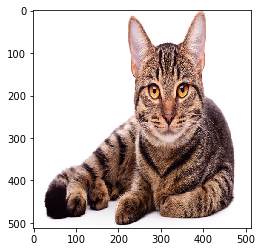

In [20]:
a = plt.imread(img_path)
a = resize(a,(512,512))
plt.imshow(a)
imgs = [a]

In [21]:
m = PersonRecognizer()

In [22]:
m.detect_people(frame=a)

[]

   class   conf xmin   ymin   xmax   ymax
[array([ 15.  ,   0.99, 326.43,  81.99, 429.56, 521.68], dtype=float32), array([ 15.  ,   0.65,  -4.74, 134.64,  50.59, 375.55], dtype=float32)]


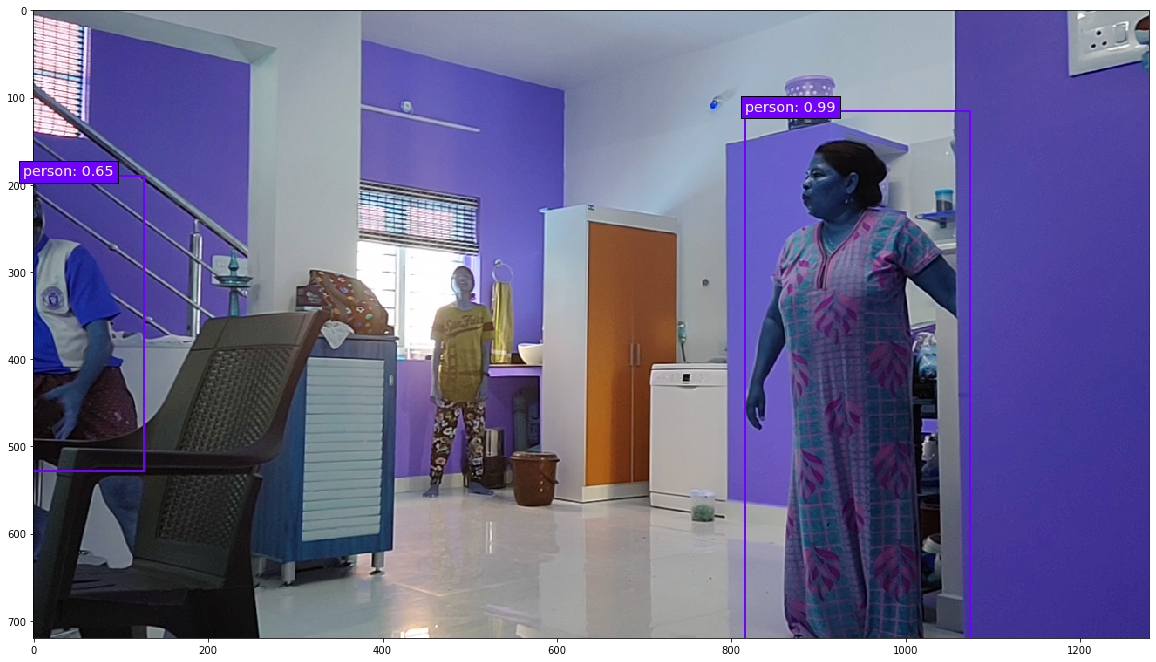

In [23]:
import cv2 
import imutils
videoPath = r"video/VID20200315124213.mp4"
qwe = cv2.VideoCapture(videoPath)
s,frame = qwe.read()
#while True:
#    cv2.imshow("qwer",frame)
#    if cv2.waitKey(1) & 0xFF == ord('q'):
#        break
#plt.imshow(frame)
qwe.release()
cv2.destroyAllWindows()
boxes = m.detect_people(frame=frame)

print('   class   conf xmin   ymin   xmax   ymax')
print(boxes)

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(frame)

current_axis = plt.gca()

for box in boxes:
    # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
    xmin = box[-4] * frame.shape[1] / img_width
    ymin = box[-3] * frame.shape[0] / img_height
    xmax = box[-2] * frame.shape[1] / img_width
    ymax = box[-1] * frame.shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})



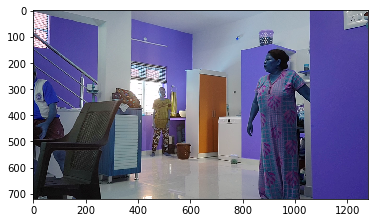

In [24]:
q = frame 
import PIL
w = PIL.Image.fromarray(q)
plt.imshow(w)

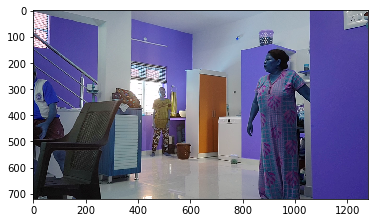

In [33]:
#plt.imshow(frame[1])
#a = resize(q,(512,512))
plt.imshow(q)
imgs = [np.array(q,dtype='int')]
imgs = np.array(imgs,dtype='uint8')

In [34]:
type(np.squeeze(imgs))

numpy.ndarray

In [35]:
m.detect_people(np.squeeze(imgs))

[array([ 15.  ,   0.99, 326.43,  81.99, 429.56, 521.68], dtype=float32),
 array([ 15.  ,   0.65,  -4.74, 134.64,  50.59, 375.55], dtype=float32)]

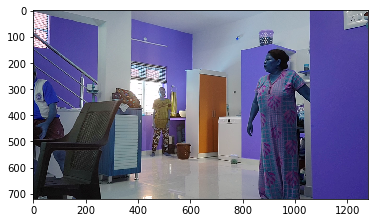

In [36]:
plt.imshow(frame)

In [37]:
m.prediction_order

['class', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']